<a href="https://colab.research.google.com/github/shivendrashahi/Cross_Sell_Prediction/blob/add-license-1/Cross_Sell_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Abstract

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

We will be using Light GBM and Catboost with and without feature engineering and will check how well our model responds.

#Import Libraries

In [2]:
pip install catboost

     |████████████████████████████████| 66.2MB 56kB/s 


In [80]:
#Importing Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm ,tnrange

#Load Data

In [81]:
# Read the csv file from url
train_data_url = "https://raw.githubusercontent.com/shivendrashahi/Cross_Sell_Prediction/main/train.csv"
test_data_url = "https://raw.githubusercontent.com/shivendrashahi/Cross_Sell_Prediction/main/test.csv"
df_train = pd.read_csv(train_data_url)
df_test = pd.read_csv(test_data_url)

In [82]:
# Peek into train dataset
print(df_train.shape)
df_train.head()

(381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [83]:
# Peek into test dataset
print(df_test.shape)
df_test.head()

(127037, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [84]:
# Check the total number of records and data type of features
print("Train Dataset")
print(f"{60*'-'}")
print(df_train.info())
print()
print("Test Dataset")
print(f"{60*'-'}")
print(df_test.info())

Train Dataset
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB
None

Test Dataset
----

So there are total 381109 records in train dataset and 127037 records in test dataset. It's look like there are no missing values but still we will verify once.

#Data Description
id : Unique ID for the customer

Gender : Gender of the customer

Age : Age of the customer

Driving_License : 0 - Customer does not have DL, 
                  1 - Customer already has DL

Region_Code : Unique code for the region of the customer

Previously_Insured : 1 - Customer already has Vehicle Insurance, 
                     0 - Customer doesn't have Vehicle Insurance

Vehicle_Age :    Age of the Vehicle 

Vehicle_Damage : 1 - Customer got his/her vehicle damaged in the past.
                 0 - Customer didn't get his/her vehicle damaged in the past.

Annual_Premium : The amount customer needs to pay as premium in the year

Policy_Sales_Channel : Anonymised Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

Vintage :    Number of Days, Customer has been associated with the company

Response    : 1 -  Customer is interested, 
              0 - Customer is not interested

#EDA

In [85]:
# Check for missing values
print("Train Dataset")
print(f"{40*'-'}")
print(df_train.isnull().sum())

print()

print("Test Dataset")
print(f"{40*'-'}")
print(df_test.isnull().sum())

Train Dataset
----------------------------------------
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Test Dataset
----------------------------------------
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64


In [86]:
df_train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


##Response

Text(0.5, 1.0, 'Response')

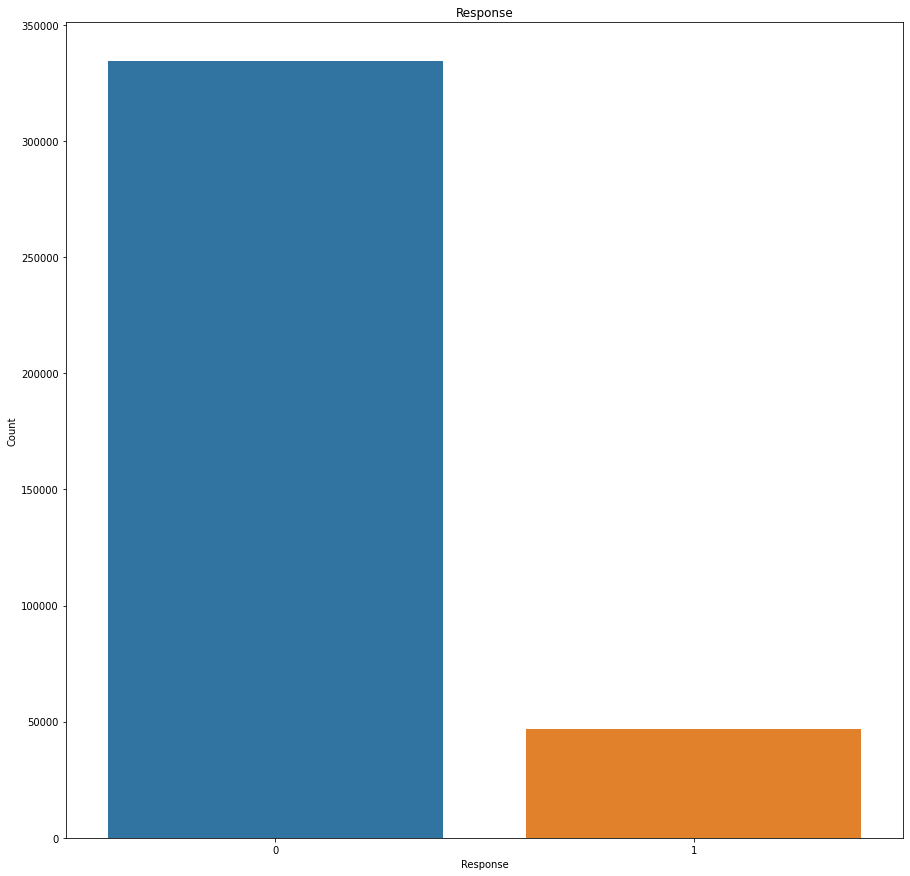

In [87]:
#Response
response = df_train.loc[:,"Response"].value_counts().rename('Count')
plt.xlabel("Response")
plt.ylabel('Count')
sns.barplot(response.index , response.values).set_title('Response')

In [88]:
response

0    334399
1     46710
Name: Count, dtype: int64

##Vintage

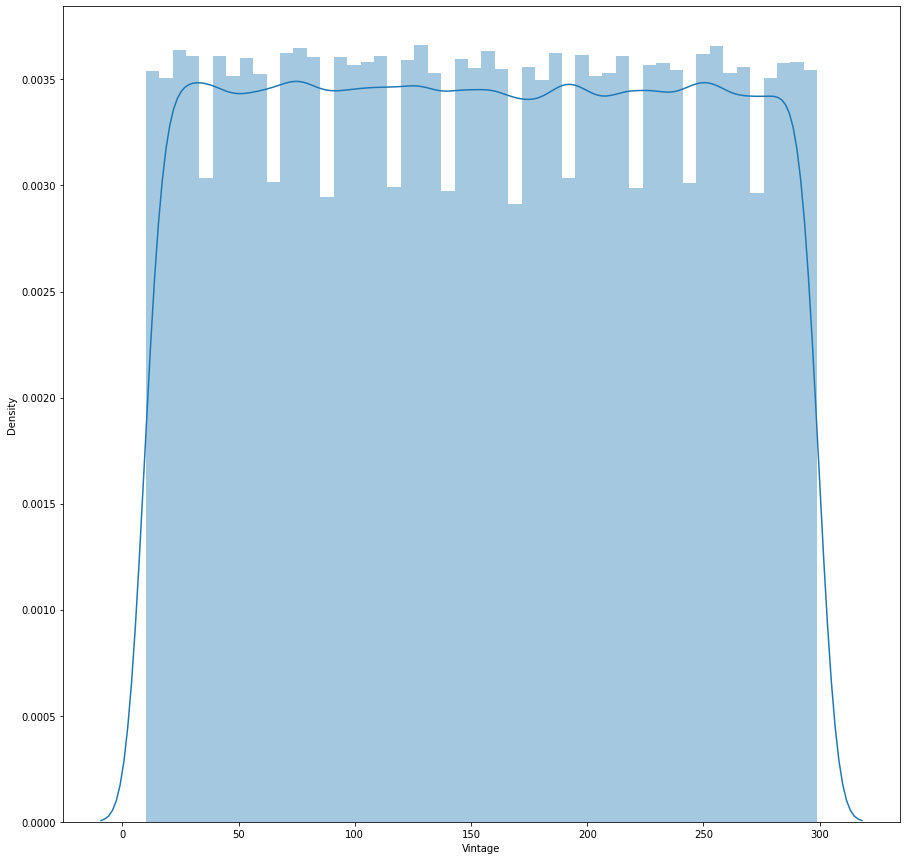

In [89]:
#Vintage
sns.distplot(df_train['Vintage'])

##Annual Premium

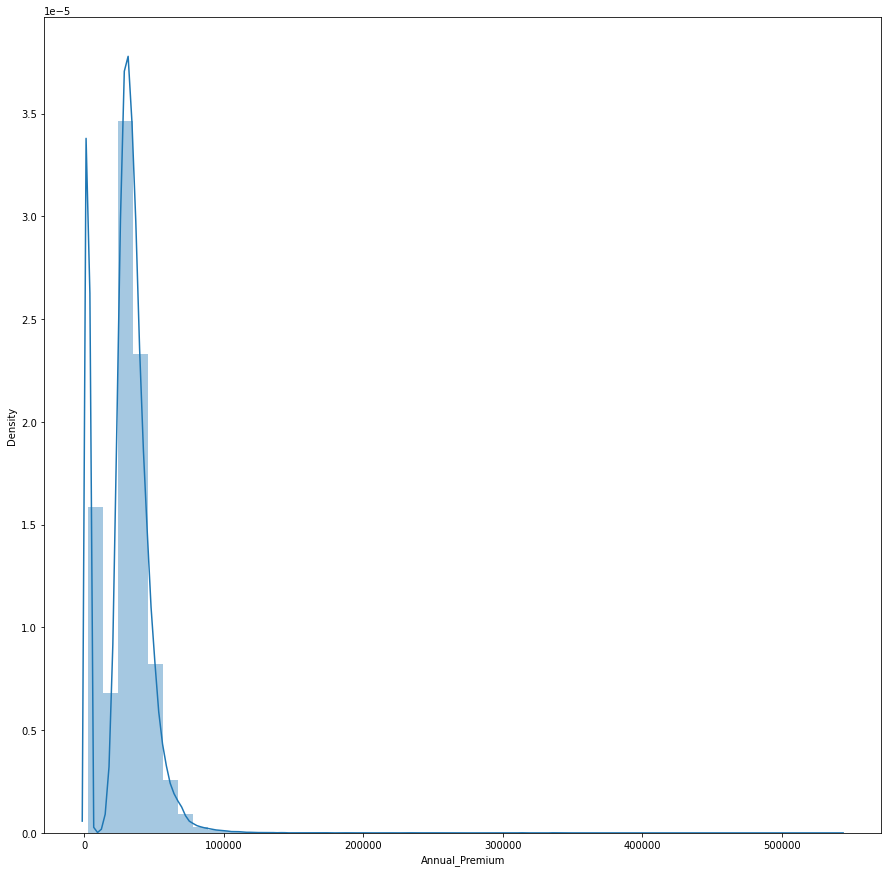

In [90]:
sns.distplot(df_train['Annual_Premium'])

##Age

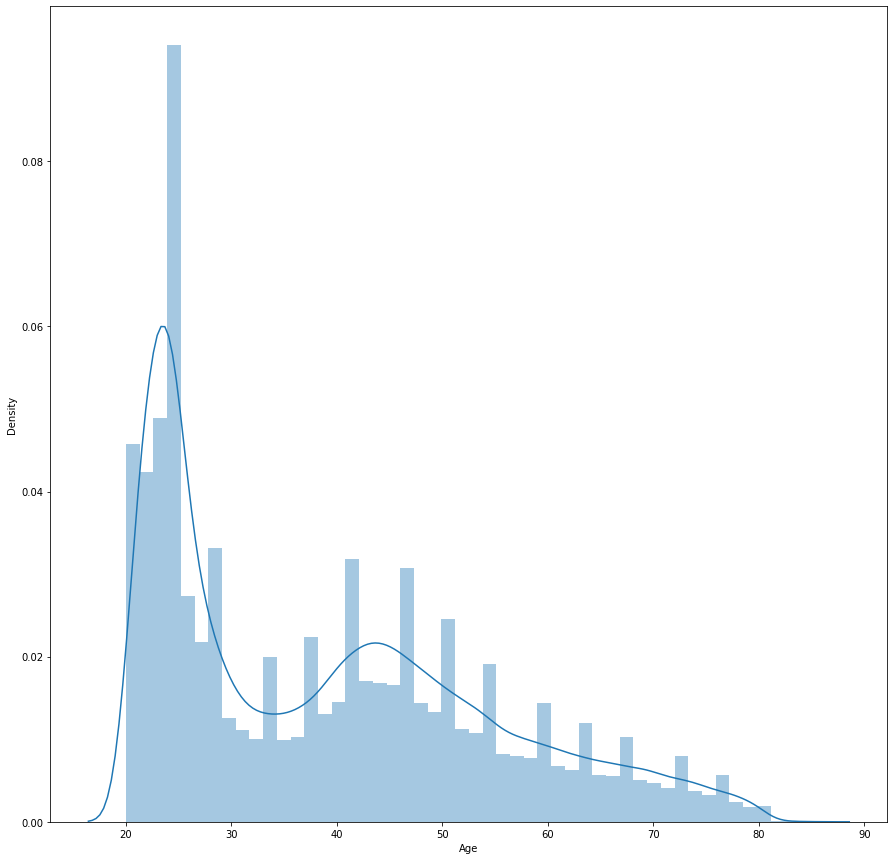

In [91]:
sns.distplot(df_train['Age'])

#Preprocessing

In [92]:
# Combine train and test for preprocessing
# Adding train_flag variable, which help to sagregate the train and test after preprocessing.
df_train['train_flag'] = 1
df_test['train_flag'] = 0

# Add target variable 'Response' in test as we need it for concatinating.
df_test['Response'] = None
print(df_train.shape, df_test.shape)
df_data = pd.concat((df_train,df_test))
print(df_data.shape)

(381109, 13) (127037, 13)
(508146, 13)


In [93]:
# Check the number of unique values in each column
print(df_data.nunique())

id                      508146
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           52062
Policy_Sales_Channel       157
Vintage                    290
Response                     2
train_flag                   2
dtype: int64


The "id" column has different value for each record, which is obvious, so we are going to drop "id" column.

Looking at the "Age" variable the we can say that it can be treated as continuous as well as categorical variable but for the base model we will keep it as continuous variable.

Apart from "Age" there is only two continuous variable i.e. "Annual Premium" and "Vintage", rest all are categorical columns.

In [94]:
# Drop id column
df_data.drop(['id'], axis=1, inplace = True)

In [95]:
df_data.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'train_flag'],
      dtype='object')

In [96]:
# Peek into categorical variables
categorical_variables = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']
target_variable = 'Response'
df_data[categorical_variables].head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel
0,Male,1,28.0,0,> 2 Years,Yes,26.0
1,Male,1,3.0,0,1-2 Year,No,26.0
2,Male,1,28.0,0,> 2 Years,Yes,26.0
3,Male,1,11.0,1,< 1 Year,No,152.0
4,Female,1,41.0,1,< 1 Year,No,152.0


So we need to encode "Gender", "Vehicle_Age" and "Vehicle_Damage" variables and also convert the datatype of float to int.

In [97]:
# Encode categorical Variables
# Encode binary features
df_data['Gender'] = df_data['Gender'].replace({'Male':1, 'Female':0})
df_data['Vehicle_Damage'] = df_data['Vehicle_Damage'].replace({'Yes':1, 'No':0})

In [98]:
# Check the unique values in "Vehicle_Age" column
df_data['Vehicle_Age'].value_counts()

1-2 Year     267015
< 1 Year     219805
> 2 Years     21326
Name: Vehicle_Age, dtype: int64

So there are three unique values in "Vehicle_Age" column i.e. "< 1 Year", "1-2 Year", "> 2 Years".

Since, it ia an ordinal feature, we are going to map "< 1 Year" to 1, "1-2 Year" to 2 and "> 2 Years" to 3.

In [99]:
# Encode "Vehicle_Age" (it is an ordinal variable, so we need to take care of order)
# create dictionary of ordinal to integer mapping
vehicle_age_ord = {'< 1 Year':1,'1-2 Year':2,'> 2 Years':3}

# apply using map
df_data['Vehicle_Age'] = df_data.Vehicle_Age.map(vehicle_age_ord)

In [100]:
# Now check for the datatype
df_data.dtypes

Gender                    int64
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age               int64
Vehicle_Damage            int64
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                 object
train_flag                int64
dtype: object

We need to convert datatype of each variable to int, so that we can feed our data to model.

In [101]:
# Convert data of categorical variables to int
df_data['Region_Code'] = df_data['Region_Code'].astype('int')
#df_data['Annual_Premium'] = df_data['Annual_Premium'].astype('int')
df_data['Policy_Sales_Channel'] = df_data['Policy_Sales_Channel'].astype('int')
#df_data['Response'] = df_data[df_data.train_flag==1].astype('int')

In [102]:
# Store id column of test for submission
test_id = df_test['id']

# Segregate train and test data set
df_train, df_test = df_data[df_data.train_flag==1], df_data[df_data.train_flag==0]

In [103]:
# Drop additional Columns
df_train = df_train.drop(['train_flag'], axis=1)
df_test = df_test.drop(['train_flag', 'Response'], axis=1)

In [104]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  object 
dtypes: float64(1), int64(9), object(1)
memory usage: 34.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 127037 entries, 0 to 127036
Data columns (total 10 columns):
 #   Column                Non-Nul

In [105]:
# Convert "Response" in train to int
df_train['Response'] = df_train['Response'].astype(int)

In [106]:
# Separate feature column names
features = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
# Verify column names
target_variable, features, categorical_variables
#print(features)

('Response',
 ['Gender',
  'Age',
  'Driving_License',
  'Region_Code',
  'Previously_Insured',
  'Vehicle_Age',
  'Vehicle_Damage',
  'Annual_Premium',
  'Policy_Sales_Channel',
  'Vintage'],
 ['Gender',
  'Driving_License',
  'Region_Code',
  'Previously_Insured',
  'Vehicle_Age',
  'Vehicle_Damage',
  'Policy_Sales_Channel'])

In [107]:
# Split train data in train and validation
from sklearn.model_selection import train_test_split
train_X, val_X, train_Y, val_Y = train_test_split(df_train[features], df_train[target_variable], test_size=0.3, random_state=42, stratify = df_train[target_variable], shuffle=True)

In [108]:
print(train_X.shape)
print(train_Y.shape)
print(val_X.shape)
print(val_Y.shape)

(266776, 10)
(266776,)
(114333, 10)
(114333,)


#LGBM Classifier

In [109]:
# Set parameter for classifier
params = {}
params['learning_rate'] =0.06
params['max_depth'] = 50
params['n_estimators'] = 500
params['objective'] = 'binary'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree'] = 0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.6
params['reg_lambda'] = 1.1

In [110]:
# Initialize and fit classifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
clf = lgb.LGBMClassifier(**params)
clf.fit(train_X, train_Y, early_stopping_rounds=100, eval_set=[(train_X, train_Y), (val_X, val_Y)], eval_metric ='binary_logloss', verbose=True, categorical_feature=categorical_variables)

[1]	training's binary_logloss: 0.361158	training's binary_logloss: 0.361158	valid_1's binary_logloss: 0.361118	valid_1's binary_logloss: 0.361118
Training until validation scores don't improve for 100 rounds.
[2]	training's binary_logloss: 0.351918	training's binary_logloss: 0.351918	valid_1's binary_logloss: 0.351857	valid_1's binary_logloss: 0.351857
[3]	training's binary_logloss: 0.344373	training's binary_logloss: 0.344373	valid_1's binary_logloss: 0.344275	valid_1's binary_logloss: 0.344275
[4]	training's binary_logloss: 0.337385	training's binary_logloss: 0.337385	valid_1's binary_logloss: 0.337286	valid_1's binary_logloss: 0.337286
[5]	training's binary_logloss: 0.331585	training's binary_logloss: 0.331585	valid_1's binary_logloss: 0.331477	valid_1's binary_logloss: 0.331477
[6]	training's binary_logloss: 0.326222	training's binary_logloss: 0.326222	valid_1's binary_logloss: 0.326118	valid_1's binary_logloss: 0.326118
[7]	training's binary_logloss: 0.321198	training's binary_log

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.06, max_depth=50,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=55, min_split_gain=0.0, n_estimators=500,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=42,
               reg_alpha=1.6, reg_lambda=1.1, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0)

In [111]:
eval_score = accuracy_score(val_Y, clf.predict(val_X))
print('Eval Accuracy : {}'.format(eval_score))

Eval Accuracy : 0.8775943953189368


In [113]:
best_iteration = clf.best_iteration_
params['n_estimators'] = best_iteration
print(params)

{'learning_rate': 0.06, 'max_depth': 50, 'n_estimators': 159, 'objective': 'binary', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.6, 'reg_lambda': 1.1}


In [114]:
# combine train and validation dataset
train_val_X = pd.concat((train_X, val_X))
train_val_Y = pd.concat((train_Y, val_Y))

In [115]:
clf = lgb.LGBMClassifier(**params)
clf.fit(train_val_X,train_val_Y,eval_metric = 'binary_logloss', verbose=False, categorical_feature=categorical_variables)
eval_score_accuracy =accuracy_score(train_val_Y,clf.predict(train_val_X))
print('Eval Accuracy : {}'.format(eval_score_accuracy))
# 0.8779246882125586

Eval Accuracy : 0.8779246882125586


In [116]:
predictions = clf.predict(df_test[features])
np.unique(predictions,return_counts=True)

(array([0, 1]), array([126842,    195]))

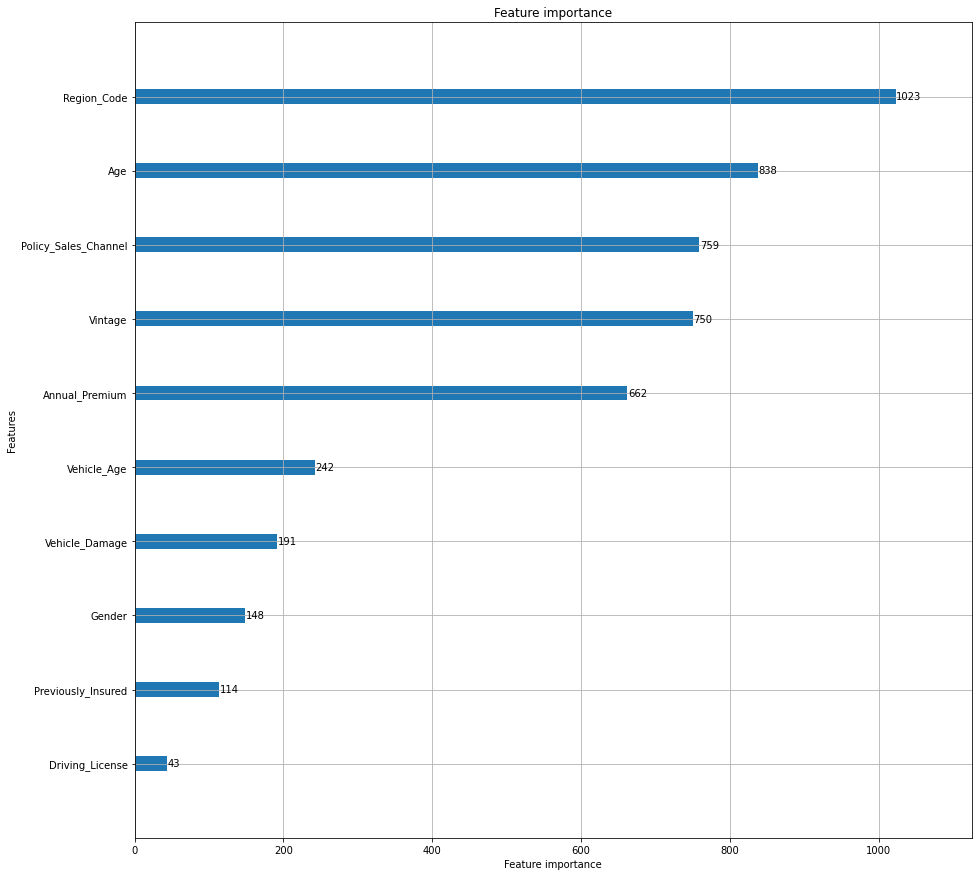

In [117]:
#plt.rcParams['figure.figsize'] = (12,50)
lgb.plot_importance(clf)
plt.show()

In [118]:
#Submission 1
lgb_pred= clf.predict_proba(df_test[features])[:, 1]
sub_df = pd.DataFrame({"id":test_id})
sub_df["Response"] = lgb_pred
#predict_proba()
sub_df.to_csv("/content/sub_lgb_prob.csv", index=False)

#Catboost Classifier

In [119]:
# Split train data in train and validation
train_X, val_X, train_Y, val_Y = train_test_split(df_train[features], df_train[target_variable], test_size=0.25, random_state=42, stratify = df_train[target_variable], shuffle=True)

In [120]:
# Catboost Classifier
from catboost import CatBoostClassifier
#from sklearn.metrics import accuracy_score
catb = CatBoostClassifier()
catb= catb.fit(train_X, train_Y, cat_features=categorical_variables,eval_set=(val_X, val_Y),plot=True,early_stopping_rounds=30,verbose=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.128106
0:	learn: 0.4922538	test: 0.4923686	best: 0.4923686 (0)	total: 418ms	remaining: 6m 57s
100:	learn: 0.2632004	test: 0.2640125	best: 0.2640125 (100)	total: 27.5s	remaining: 4m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.2638625276
bestIteration = 166

Shrink model to first 167 iterations.


In [121]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

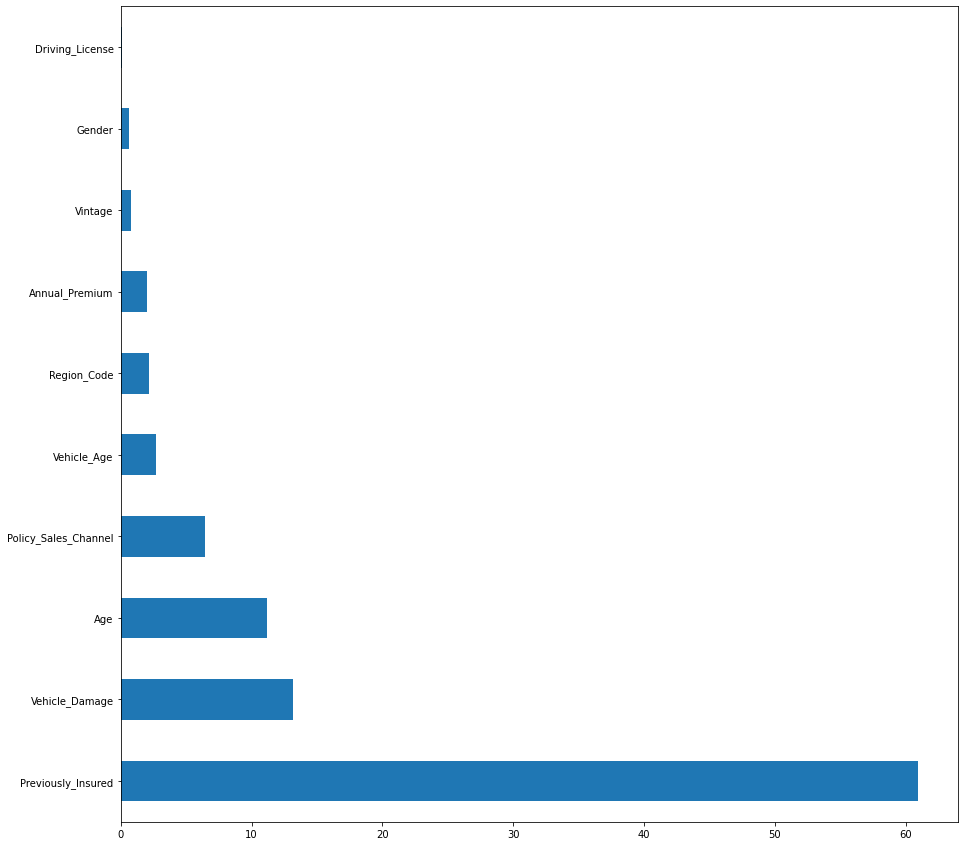

In [122]:
feat_importances = pd.Series(catb.feature_importances_, index=train_X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [125]:
#Submission 2
cat_pred= catb.predict_proba(df_test)[:, 1]


sub_df = pd.DataFrame({"id":test_id})
sub_df["Response"] = cat_pred


sub_df.to_csv("/content/sub_cat.csv", index=False)

#Feature Engineering

##Concat Features

In [126]:
df_train['Policy_Region'] = df_train['Policy_Sales_Channel'].astype(str)+'_'+df_train['Region_Code'].astype(str)

df_test['Policy_Region'] = df_test['Policy_Sales_Channel'].astype(str)+'_'+df_test['Region_Code'].astype(str)

df_train['Vehicle_Age_License'] = df_train['Vehicle_Age'].astype(str)+'_'+df_train['Driving_License'].astype(str)

df_test['Vehicle_Age_License'] = df_test['Vehicle_Age'].astype(str)+'_'+df_test['Driving_License'].astype(str)

In [127]:
cat_features = ['Gender','Driving_License','Region_Code','Previously_Insured',
                'Vehicle_Damage','Policy_Sales_Channel','Policy_Region',
                'Vehicle_Age','Vintage','Annual_Premium','Vehicle_Age_License']

cont_features = ['Age']

label = 'Response'

In [128]:
def encode_cat_cols(train, test, cat_cols): #target

    train_df = df_train.copy()
    
    test_df = df_test.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}

    for col in cat_cols:
        
        if col!= 'Vehicle_Age':
        
            le = LabelEncoder()

            le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())

            train_df[col] = le.transform(train_df[[col]])

            test_df[col] = le.transform(test_df[[col]])

            le_dict[col] = le
        
    train_df['Vehicle_Age'] = train_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})
    
    test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})

    le = LabelEncoder()
    
    train_df[label] = le.fit_transform(train_df[[label]])
    
    le_dict[label] = le
    
    
    return train_df, test_df, le_dict


In [129]:
train_df, test_df, le_dict = encode_cat_cols(df_train,df_test,cat_features)

In [130]:
train_df = train_df[~train_df.Policy_Sales_Channel.isin(list(set(train_df.Policy_Sales_Channel)-set(test_df.Policy_Sales_Channel)))]

#test_df.loc[(test_df.Policy_Sales_Channel.isin(list(set(test_df.Policy_Sales_Channel) - set(train_df.Policy_Sales_Channel)))),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==137),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==136),'Policy_Sales_Channel'] = -1

In [131]:
#Used only for XgBoost and LightGBM
#test_df.loc[(test_df.Annual_Premium.isin(list(set(test_df.Annual_Premium) - set(train_df.Annual_Premium)))),'Annual_Premium'] = -1

In [132]:
train_df['train'] = 1

test_df['train'] = 0

combined_data = pd.concat([train_df,test_df],axis =0).reset_index(drop = True).copy()

##Feature Binning

In [133]:
premium_discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

combined_data['Premium_Bins'] =premium_discretizer.fit_transform(combined_data['Annual_Premium'].values.reshape(-1,1)).astype(int)

age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

combined_data['Age_Bins'] =age_discretizer.fit_transform(combined_data['Age'].values.reshape(-1,1)).astype(int)

In [134]:
combined_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Policy_Region,Vehicle_Age_License,train,Premium_Bins,Age_Bins
0,1,44,1,28,0,NaN,1,24158,24,207,1.0,1597,5,1,5,6
1,1,76,1,3,0,NaN,0,17240,24,173,0.0,1599,3,1,3,9
2,1,47,1,28,0,NaN,1,21998,24,17,1.0,1597,5,1,4,7
3,1,21,1,11,1,NaN,0,12323,147,193,0.0,782,1,1,2,0
4,0,29,1,41,1,NaN,0,11200,147,29,0.0,815,1,1,1,4


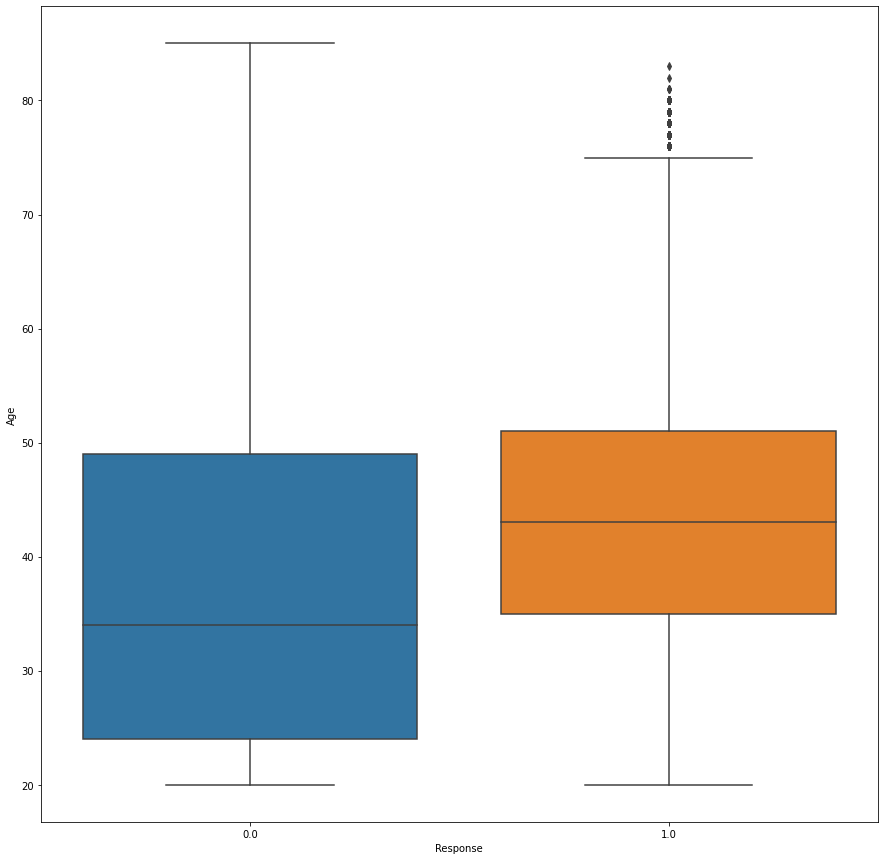

In [135]:
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Age'])

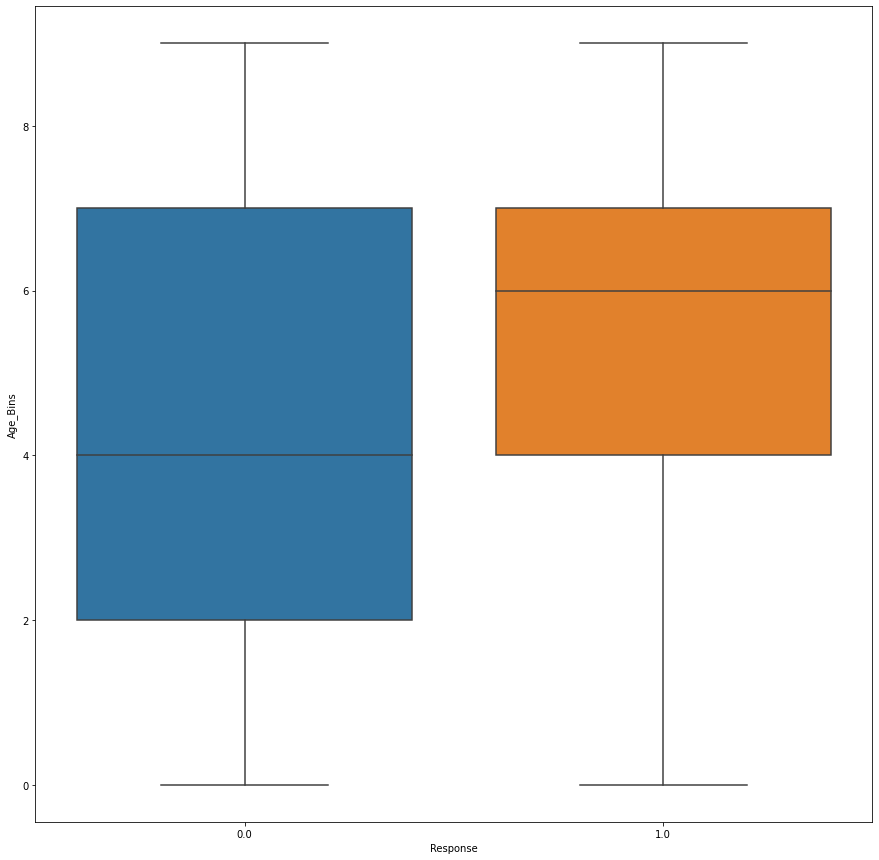

In [136]:
# Age Bin demarcates two classses better(compare the follwing graph with the above one)
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Age_Bins'])

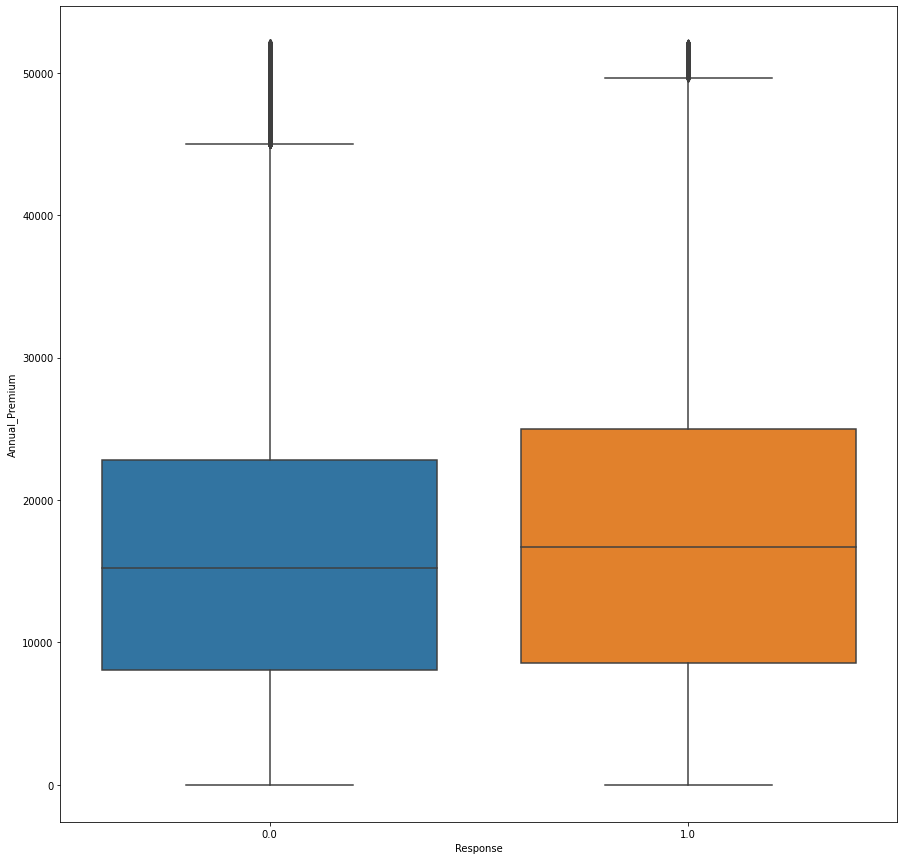

In [137]:
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Annual_Premium'])

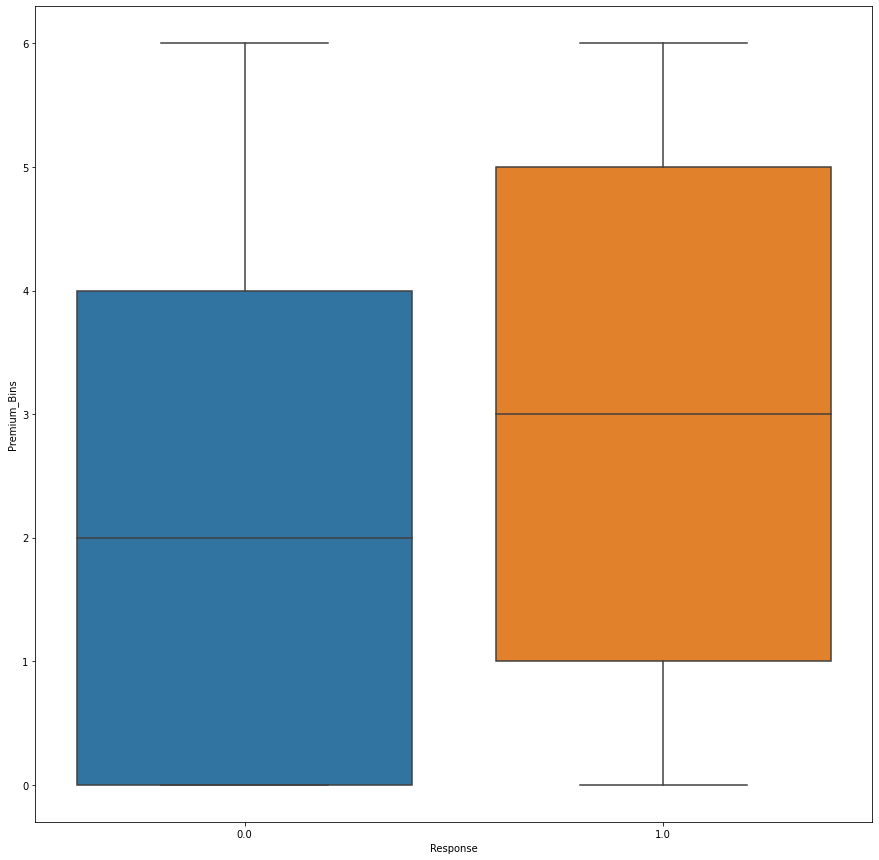

In [138]:
# the same can be seen after binning annual premium
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Premium_Bins'])

##Feature Counts

In [139]:
gender_counts = combined_data['Gender'].value_counts().to_dict()

combined_data['Gender_Counts'] = combined_data['Gender'].map(gender_counts)

region_counts = combined_data['Region_Code'].value_counts().to_dict()

combined_data['Region_counts'] = combined_data['Region_Code'].map(region_counts)

vehicle_age_counts = combined_data['Vehicle_Age'].value_counts().to_dict()

combined_data['Vehicle_Age_Counts'] = combined_data['Vehicle_Age'].map(vehicle_age_counts)

In [140]:
combined_data.sample()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Policy_Region,Vehicle_Age_License,train,Premium_Bins,Age_Bins,Gender_Counts,Region_counts,Vehicle_Age_Counts
112597,0,24,1,11,0,NaN,0,16935,147,285,0.0,782,1,1,3,2,233811,12328,NaN


##Feature Aggregations

In [141]:
combined_data['Nunq_Policy_Per_Region'] = combined_data.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique') 

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] = combined_data.groupby('Region_Code')['Annual_Premium'].transform('std').fillna(-1) 

combined_data['Nunq_Region_Per_Premium'] = combined_data.groupby('Annual_Premium')['Region_Code'].transform('nunique')

# 1230.45 can be split into “1230” and “45”. LGBM cannot see these pieces on its own, you need to split them.
combined_data['SDev_Annual_Premium_Per_Region_Code_dec'] = combined_data['SDev_Annual_Premium_Per_Region_Code_int'] %1

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] =combined_data['SDev_Annual_Premium_Per_Region_Code_int'].astype(int)


combined_data['Avg_Policy_Region_Age'] = combined_data.groupby(['Policy_Region'])['Age'].transform('mean')

combined_data['Avg_Policy_Region_Premium'] = combined_data.groupby(['Policy_Region'])['Annual_Premium'].transform('mean') 

combined_data['Avg_Region_Premium'] = combined_data.groupby(['Region_Code'])['Annual_Premium'].transform('mean')

combined_data['Nunq_Premium_Region'] = combined_data.groupby(['Annual_Premium'])['Region_Code'].transform('nunique')

In [142]:
combined_data.sample()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Policy_Region,Vehicle_Age_License,train,Premium_Bins,Age_Bins,Gender_Counts,Region_counts,Vehicle_Age_Counts,Nunq_Policy_Per_Region,SDev_Annual_Premium_Per_Region_Code_int,Nunq_Region_Per_Premium,SDev_Annual_Premium_Per_Region_Code_dec,Avg_Policy_Region_Age,Avg_Policy_Region_Premium,Avg_Region_Premium,Nunq_Premium_Region
485638,0,65,1,28,1,NaN,0,20997,24,198,NaN,1597,3,0,4,9,233811,141929,NaN,121,12418,12,0.969714,51.396153,23887.148512,22677.86179,12


In [143]:
#combined_data['f4'] = combined_data.groupby(['Vehicle_Age'])['Annual_Premium'].transform('max')-combined_data.groupby(['Vehicle_Age'])['Annual_Premium'].transform('min')
#combined_data['f1'] =combined_data['Annual_Premium'] /(combined_data['Vintage']/365)


#combined_data['f2'] = combined_data.groupby(['Premium_Bins'])['Annual_Premium'].transform('max')-combined_data.groupby(['Premium_Bins'])['Annual_Premium'].transform('min')
#combined_data['f2'] = combined_data.groupby(['Annual_Premium'])['Vintage'].transform('nunique')

In [144]:
train_df = combined_data[combined_data['train']==1]

test_df = combined_data[combined_data['train']==0]

In [145]:
# Remove duplicate rows---> More trustworthy CV
cols = ['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
        'Annual_Premium','Policy_Sales_Channel', 'Vintage']

train_df = train_df[~train_df.loc[:,cols].duplicated(keep = 'first')].reset_index(drop=True)

In [146]:
target = train_df['Response']

train_df = train_df.drop(columns =['train','Response'])

test_df = test_df.drop(columns=['train','Response'])

In [147]:
test_size = 0.34

train_df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Policy_Region,Vehicle_Age_License,Premium_Bins,Age_Bins,Gender_Counts,Region_counts,Vehicle_Age_Counts,Nunq_Policy_Per_Region,SDev_Annual_Premium_Per_Region_Code_int,Nunq_Region_Per_Premium,SDev_Annual_Premium_Per_Region_Code_dec,Avg_Policy_Region_Age,Avg_Policy_Region_Premium,Avg_Region_Premium,Nunq_Premium_Region
0,1,44,1,28,0,NaN,1,24158,24,207,1597,5,5,6,274307,141929,NaN,121,12418,6,0.969714,51.396153,23887.148512,22677.861790,6
1,1,76,1,3,0,NaN,0,17240,24,173,1599,3,3,9,274307,12349,NaN,64,9506,10,0.110790,50.517411,12237.779464,10934.847194,10
2,1,47,1,28,0,NaN,1,21998,24,17,1597,5,4,7,274307,141929,NaN,121,12418,11,0.969714,51.396153,23887.148512,22677.861790,11
3,1,21,1,11,1,NaN,0,12323,147,193,782,1,2,0,274307,12328,NaN,53,9800,12,0.449872,25.735264,14232.640980,13361.517278,12
4,0,29,1,41,1,NaN,0,11200,147,29,815,1,1,4,233811,24399,NaN,67,10606,11,0.526628,26.792402,16507.378336,15963.029550,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380686,1,74,1,26,1,NaN,0,13874,24,78,1595,3,2,9,274307,3461,NaN,42,8705,12,0.776019,49.357349,16082.953890,14721.989021,12
380687,1,30,1,37,1,NaN,0,23720,147,121,810,1,5,4,274307,7342,NaN,51,8881,4,0.060071,26.166625,14511.676143,14061.525061,4
380688,1,21,1,30,1,NaN,0,18822,155,151,1189,1,3,0,274307,16276,NaN,55,7885,10,0.670013,24.784893,9344.776683,11344.417793,10
380689,0,68,1,14,0,NaN,1,28318,119,64,339,5,5,9,233811,6249,NaN,37,9065,4,0.722325,46.691176,12871.089286,11745.857417,4


#Light GBM after Feature Engineering

In [148]:
def feature_importance(model, X_train):

    fI = model.feature_importances_
    
    print(fI)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, fI)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 251256 rows of holdout = 129435
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.281043	valid_0's auc: 0.856495	valid_0's binary_logloss: 0.281043
[200]	valid_0's binary_logloss: 0.268286	valid_0's auc: 0.858648	valid_0's binary_logloss: 0.268286
[300]	valid_0's binary_logloss: 0.264939	valid_0's auc: 0.859323	valid_0's binary_logloss: 0.264939
[400]	valid_0's binary_logloss: 0.264006	valid_0's auc: 0.85951	valid_0's binary_logloss: 0.264006
[500]	valid_0's binary_logloss: 0.263735	valid_0's auc: 0.859552	valid_0's binary_logloss: 0.263735
Early stopping, best iteration is:
[478]	valid_0's binary_logloss: 0.263769	valid_0's auc: 0.859564	valid_0's binary_logloss: 0.263769
LGB Val OOF AUC= 0.8595637149597107
####################################################################################################


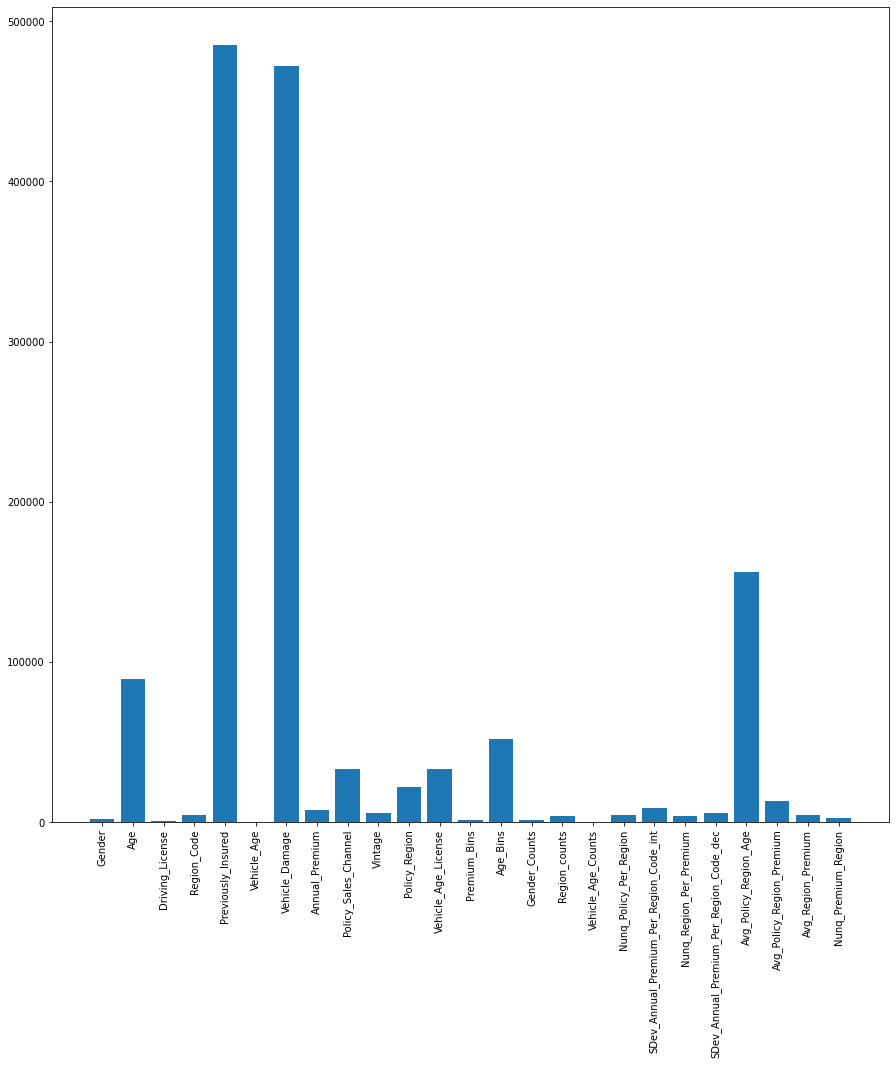

Fold 1
 rows of train = 251256 rows of holdout = 129435
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.281321	valid_0's auc: 0.855585	valid_0's binary_logloss: 0.281321
[200]	valid_0's binary_logloss: 0.268605	valid_0's auc: 0.857828	valid_0's binary_logloss: 0.268605
[300]	valid_0's binary_logloss: 0.265308	valid_0's auc: 0.858337	valid_0's binary_logloss: 0.265308
[400]	valid_0's binary_logloss: 0.264391	valid_0's auc: 0.858486	valid_0's binary_logloss: 0.264391
[500]	valid_0's binary_logloss: 0.26411	valid_0's auc: 0.85853	valid_0's binary_logloss: 0.26411
[600]	valid_0's binary_logloss: 0.263999	valid_0's auc: 0.858558	valid_0's binary_logloss: 0.263999
Early stopping, best iteration is:
[560]	valid_0's binary_logloss: 0.264015	valid_0's auc: 0.858573	valid_0's binary_logloss: 0.264015
LGB Val OOF AUC= 0.8585733460334102
####################################################################################################
Fold 2
 rows

In [149]:
%%time
##LightGBM

cat_features = ['Driving_License','Gender','Region_Code','Previously_Insured','Vehicle_Damage',
                'Policy_Sales_Channel','Policy_Region','Vehicle_Age','Vintage',
                'Annual_Premium','Vehicle_Age_License','Premium_Bins']

cont_features = ['Age','Age_Bins']

probs_lgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])

    X_train_cv,y_train_cv = train_df.copy(), target.copy()

    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = lgb.LGBMClassifier(boosting_type='gbdt',
                                 n_estimators=10000,
                                 max_depth=10,
                                 learning_rate=0.02,
                                 subsample=0.9,
                                 colsample_bytree=0.4,
                                 objective ='binary',
                                 random_state = 1,
                                 importance_type='gain',
                                 reg_alpha=2,
                                 reg_lambda=2
                                 #cat_features=cat_features
                                )        
        
        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['binary_logloss','auc'],
                    early_stopping_rounds=100)
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_lgb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)

        avg_loss.append(clf.best_score_['valid_0']['binary_logloss'])

        print ('LGB Val OOF AUC=',roc)

        print('#'*100)

        if i==0:
            feature_importance(clf,X_train_cv)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))


In [152]:

#Submission 3

sub_df = pd.DataFrame({"id":test_id})
sub_df["Response"] = probs_lgb


sub_df.to_csv("/content/sub_lgb_featEngg.csv", index=False)

#CatBoost after Feature Engineering

In [164]:
cat_features = ['Driving_License','Gender','Region_Code','Previously_Insured','Vehicle_Damage',
                'Policy_Sales_Channel','Policy_Region','Vintage',
                'Annual_Premium','Vehicle_Age_License','Premium_Bins']

cont_features = ['Age','Age_Bins']

In [165]:
features = ['Driving_License','Gender','Region_Code','Previously_Insured','Vehicle_Damage',
                'Policy_Sales_Channel','Policy_Region','Vintage',
                'Annual_Premium','Vehicle_Age_License','Premium_Bins','Age','Age_Bins']

In [166]:
# Split train data in train and validation
train_X, val_X, train_Y, val_Y = train_test_split(train_df[features],target, test_size=0.25, random_state=42, stratify = target, shuffle=True)


In [167]:
#Catboost after feature engineering
catb = CatBoostClassifier()
catb= catb.fit(train_X[features], train_Y, cat_features=cat_features,eval_set=(val_X, val_Y),plot=True,early_stopping_rounds=30,verbose=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.128071
0:	learn: 0.4918770	test: 0.4920299	best: 0.4920299 (0)	total: 715ms	remaining: 11m 54s
100:	learn: 0.2631479	test: 0.2642732	best: 0.2642732 (100)	total: 1m	remaining: 9m 2s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.264123818
bestIteration = 154

Shrink model to first 155 iterations.


In [169]:
#Submission 4
cat_pred= catb.predict_proba(test_df[features])[:, 1]


sub_df = pd.DataFrame({"id":test_id})
sub_df["Response"] = cat_pred


sub_df.to_csv("/content/sub_cat_fe.csv", index=False)

#Conclusion


We implemented the base models without feature engineering, the LGBM did not perform well.

We added features using feature binning, concatenation, aggregation.


We can observe that the model improved after the feature engineering.

Submissions:


1.   Submission 1 - Rank 128 - Private_Score 0.8627
2.   Submission 3 - Rank 86 - Private_Score 0.8630
3.   Submission 4 - Rank 65 - Private_Score 0.8632
4.   Submission 2 - Rank 37 - Private_Score 0.8633



# Citations



1.   Feature Engineering Techniques

https://www.analyticsvidhya.com/blog/2020/10/7-feature-engineering-techniques-machine-learning/#:~:text=%207%20Feature%20Engineering%20Techniques%20in%20Machine%20Learning,be%20applied%20on%20both%20categorical%20and...%20More%20


2.   Enable Feature Binning:

https://pro.arcgis.com/en/pro-app/tool-reference/data-management/enable-feature-binning.htm#:~:text=Syntax%20%20%20Parameter%20%20%20Explanation%20,%20Value%20Table%20%201%20more%20rows%20

3.   Ridgeway, Greg (2007). Generalized Boosted Models: A guide to the gbm package.

https://cran.r-project.org/web/packages/gbm/gbm.pdf

4.   Winner approach

https://www.kaggle.com/gcspkmdr/cross-sell-cv-trees?scriptVersionId=43084700

The idea of feature engineering is taken from this notebook.

Around 10% code is referred from this notebook.

